## load the datasets

In [26]:
pip install --quiet louvain

/opt/anaconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=83811) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [45]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import scib
import louvain

In [47]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore", category=ImportWarning, message=".*AltairImportHook.find_spec() not found; falling back to find_module.*")

/opt/anaconda3/lib/python3.12/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/opt/anaconda3/lib/python3.12/tempfile.py:936: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/tmpiiogj1k4'>
  _warnings.warn(warn_message, ResourceWarning)


In [49]:
adata = anndata.read_h5ad("./human_pancreas_norm.h5ad")
adata

/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categories/tech' was written without encoding metadata.
  return func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/tech' was written without encoding metadata.


AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'

### Setting: Only a few batches have annotations

In [51]:
import pandas as pd
import numpy as np

# Function to set up the described setting with randomly selected batches for annotation
def cell_type_annotation_by_batch_random(adata, seed=42, annotation_fraction=0.5):
    # Set seed for reproducibility
    np.random.seed(seed)

    # Get the unique batches
    unique_batches = adata.obs['tech'].unique()

    # Randomly select a fraction of the batches to have annotations
    num_batches_to_annotate = int(len(unique_batches) * annotation_fraction)
    batches_with_annotations = np.random.choice(unique_batches, num_batches_to_annotate, replace=False)

    # Initialize all labels with NaN
    adata.obs['batch_labels'] = np.nan

    # Assign labels only to the selected batches
    for batch in batches_with_annotations:
        annotated_indices = adata.obs[adata.obs['tech'] == batch].index
        adata.obs.loc[annotated_indices, 'batch_labels'] = adata.obs.loc[annotated_indices, 'celltype']

    # Fill remaining NaN values with "Unknown"
    adata.obs['batch_labels'].fillna("Unknown", inplace=True)
    adata.obs['batch_labels'] = adata.obs['batch_labels'].astype('category')

    return adata

In [52]:
# Example usage
adata = cell_type_annotation_by_batch_random(adata, seed=666, annotation_fraction=0.5)

# Display the first few rows of 'tech', 'celltype', and 'batch_labels' to verify
adata.obs[['tech', 'celltype', 'batch_labels']].head()

/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/ipykernel_92702/3930657932.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['gamma', 'gamma', 'gamma', 'gamma', 'gamma', ..., 'schwann', 'mast', 'macrophage', 'epsilon', 'quiescent_stellate']
Length: 1004
Categories (14, object): ['acinar', 'activated_stellate', 'alpha', 'beta', ..., 'mast', 'quiescent_stellate', 'schwann', 't_cell']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[annotated_indices, 'batch_labels'] = adata.obs.loc[annotated_indices, 'celltype']
/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/ipykernel_92702/3930657932.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

,tech,celltype,batch_labels
D101_5,celseq,gamma,gamma
D101_43,celseq,gamma,gamma
D101_93,celseq,gamma,gamma
D102_4,celseq,gamma,gamma
D172444_23,celseq,gamma,gamma


In [56]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

In [58]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='tech')
adata = adata[:, adata.var['highly_variable']]

In [59]:
# Save the new_labels column to a CSV file
adata.obs[['batch_labels']].to_csv('./batch_labels_human_pancreas_50.csv', index=True)

# scANVI

In [26]:
# scVI
adata = adata.copy()
adata.layers['counts'] = adata.X
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="tech")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|█| 400/400 [08:49<00:00,  1.27s/it, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█| 400/400 [08:49<00:00,  1.32s/it, v_num=1, train_loss_step


In [27]:
# Save the VAE model to a file named 'model.pt'
save_path = "./model_scVI"
vae.save(save_path)

In [63]:
import scvi

# Set up the AnnData object
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="tech")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

# Now you can use the loaded model for further analysis or inference
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

INFO     File ./model_scVI/model.pt already downloaded                                                             


/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [64]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

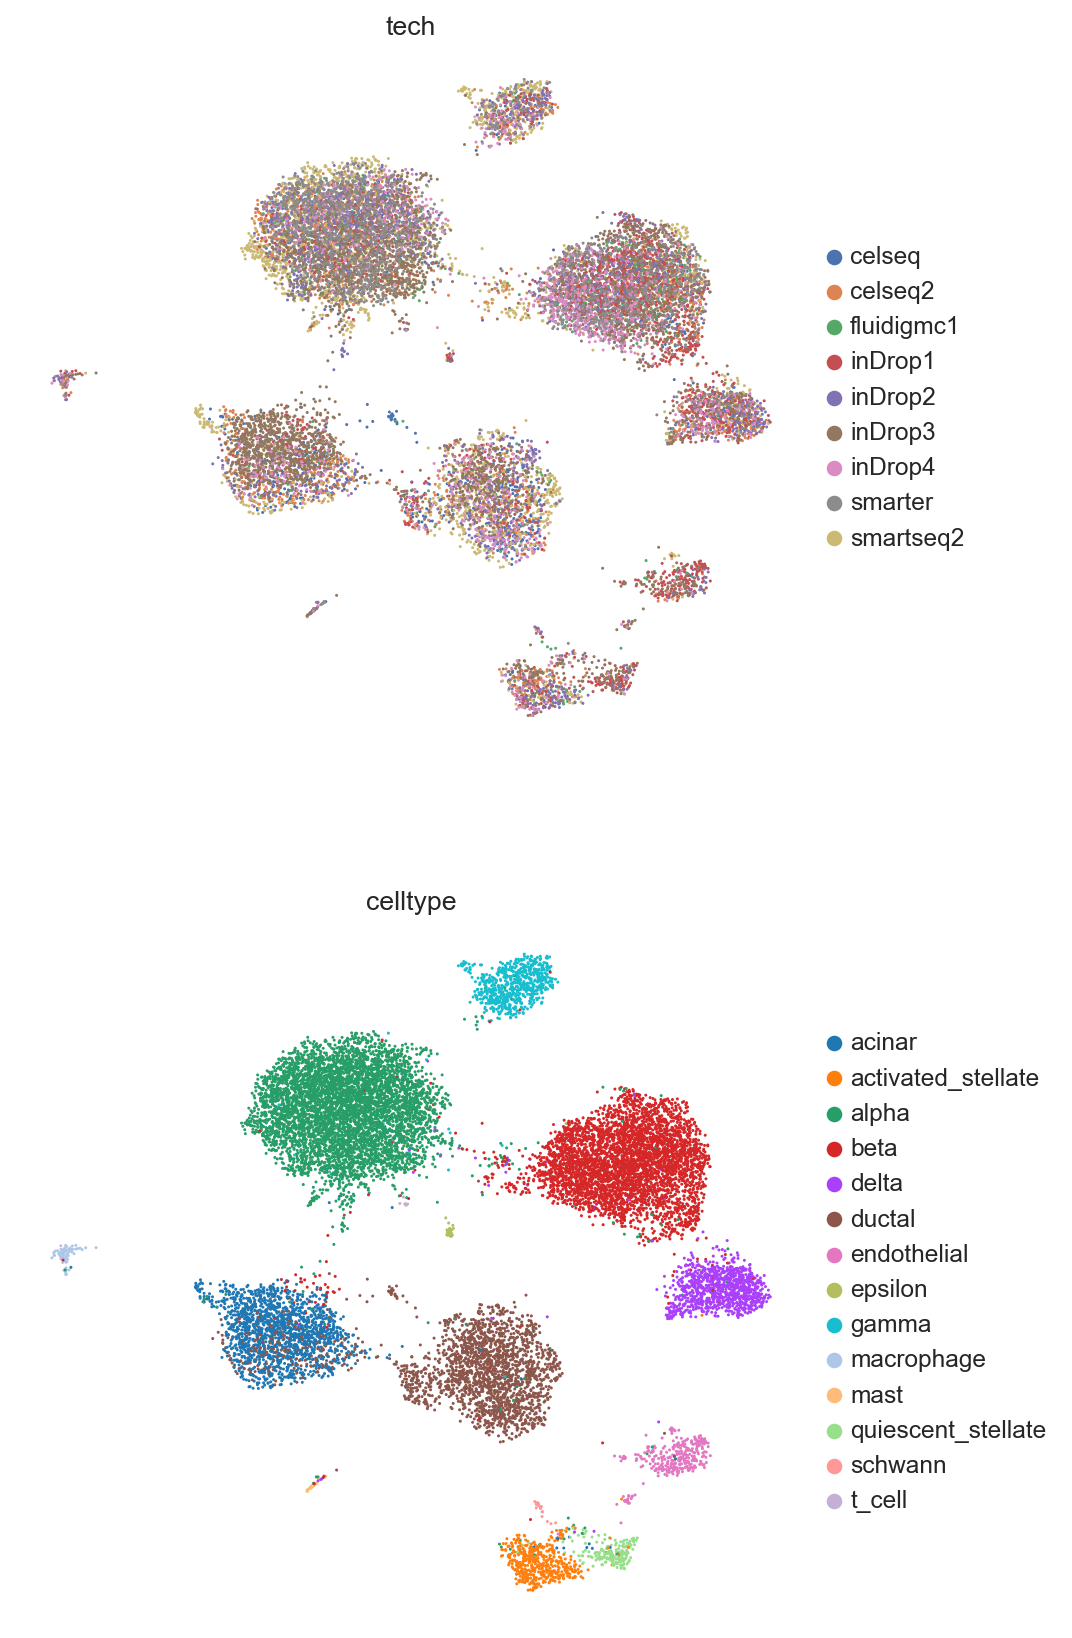

In [65]:
sc.pl.umap(adata, color=["tech", "celltype"], frameon=False, ncols=1)

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [67]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="batch_labels",
    unlabeled_category="Unknown",
)

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:186: UserWarning: Category 14 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:56: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


In [68]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|█| 20/20 [01:05<00:00,  3.29s/it, v_num=1, train_loss_step=1.3

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [01:05<00:00,  3.27s/it, v_num=1, train_loss_step=1.3


In [69]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [70]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict['X_scANVI'] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [71]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

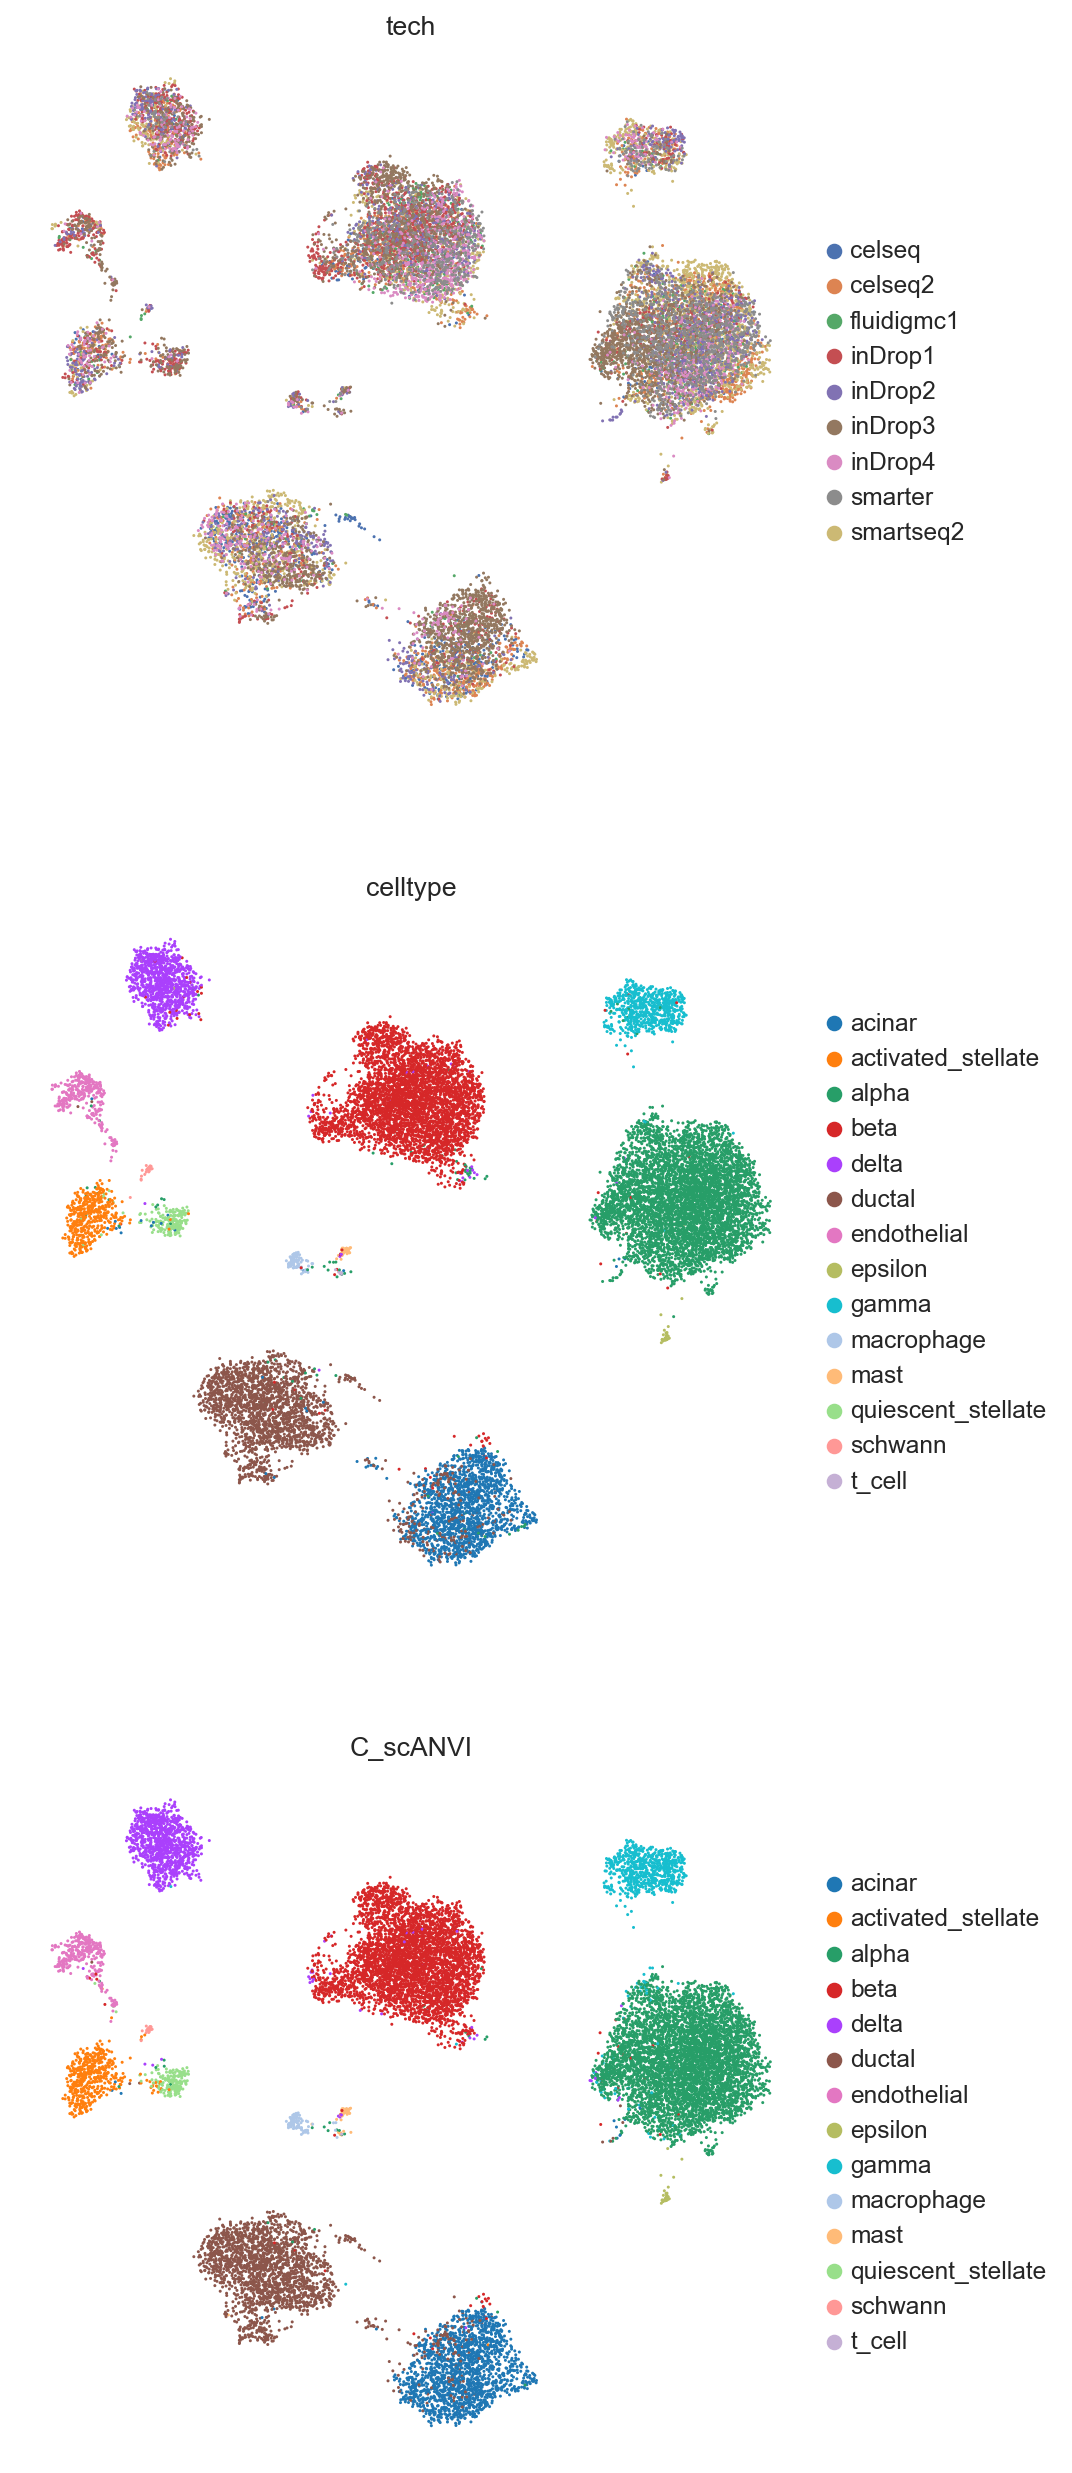

In [72]:
sc.pl.umap(adata, color=["tech", "celltype", "C_scANVI"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [79]:
train = adata.copy()

### Preprocessing Data

In [81]:
scgen.SCGEN.setup_anndata(train, batch_key="tech", labels_key="batch_labels")

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:186: UserWarning: Category 14 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


## Creating and Training the model¶

In [83]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 28/100:  28%|▎| 28/100 [03:06<08:00,  6.67s/it, v_num=1, train_loss_step=1
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1067.109. Signaling Trainer to stop.


## Batch-Removal

In [85]:
corrected_adata = model.batch_removal()
corrected_adata

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/opt/anaconda3/lib/python3.12/site-packages/scgen/_scgen.py:268: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_shared_ann = AnnData.concatenate(
/opt/anaconda3/lib/python3.12/site-packages/scgen/_scgen.py:293: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_not_shared_ann = AnnData.concatenate(
/opt/anaconda3/lib/python3.12/site-packages/scgen/_scgen.py:296: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_corrected_data = AnnData.concatena

AnnData object with n_obs × n_vars = 16382 × 2000
    obs: 'tech', 'celltype', 'size_factors', 'batch_labels', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'concat_batch'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [86]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [88]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


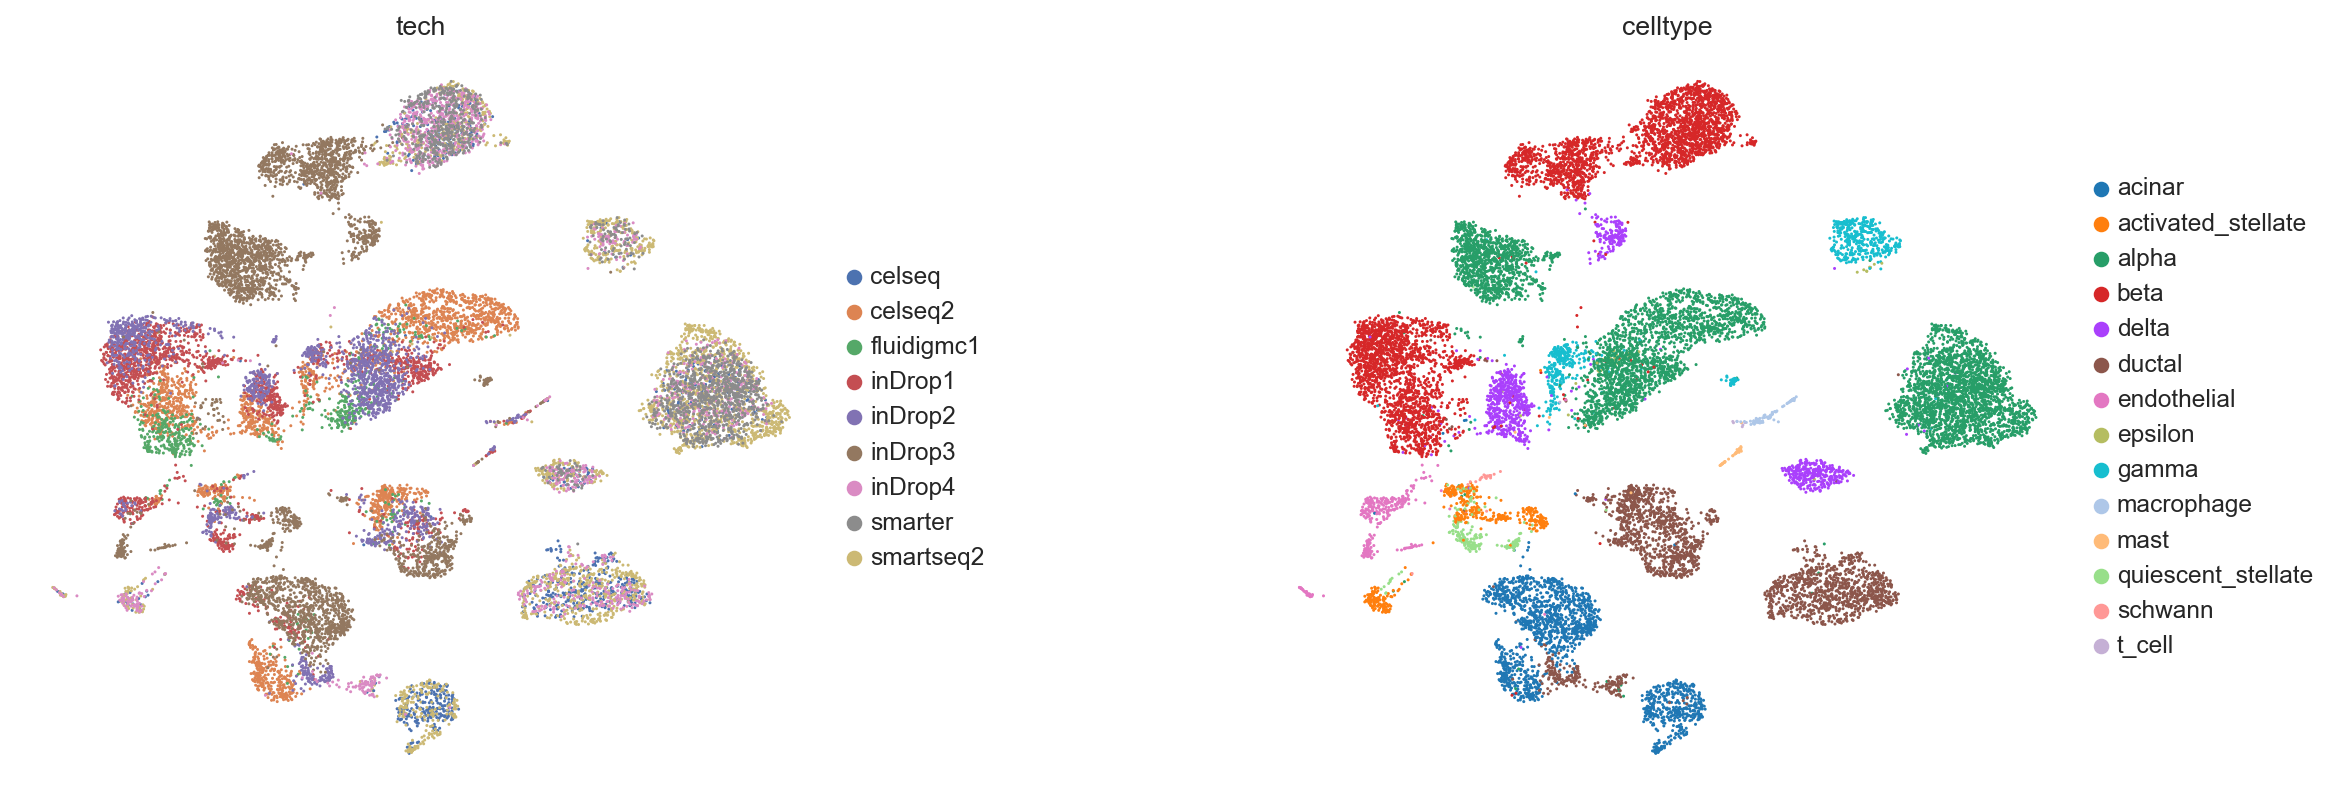

In [89]:
sc.pl.umap(corrected_adata, color=['tech', 'celltype'], wspace=0.4, frameon=False)

# STACAS

Semi-supervised integration results

In [102]:
pca_embeddings = pd.read_csv('./human_pancreas_stacas_embeddings_partially_annotated_batches_50.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [103]:
# Collect embeddings
embeddings_dict["X_stacas"] = adata.obsm['X_stacas']

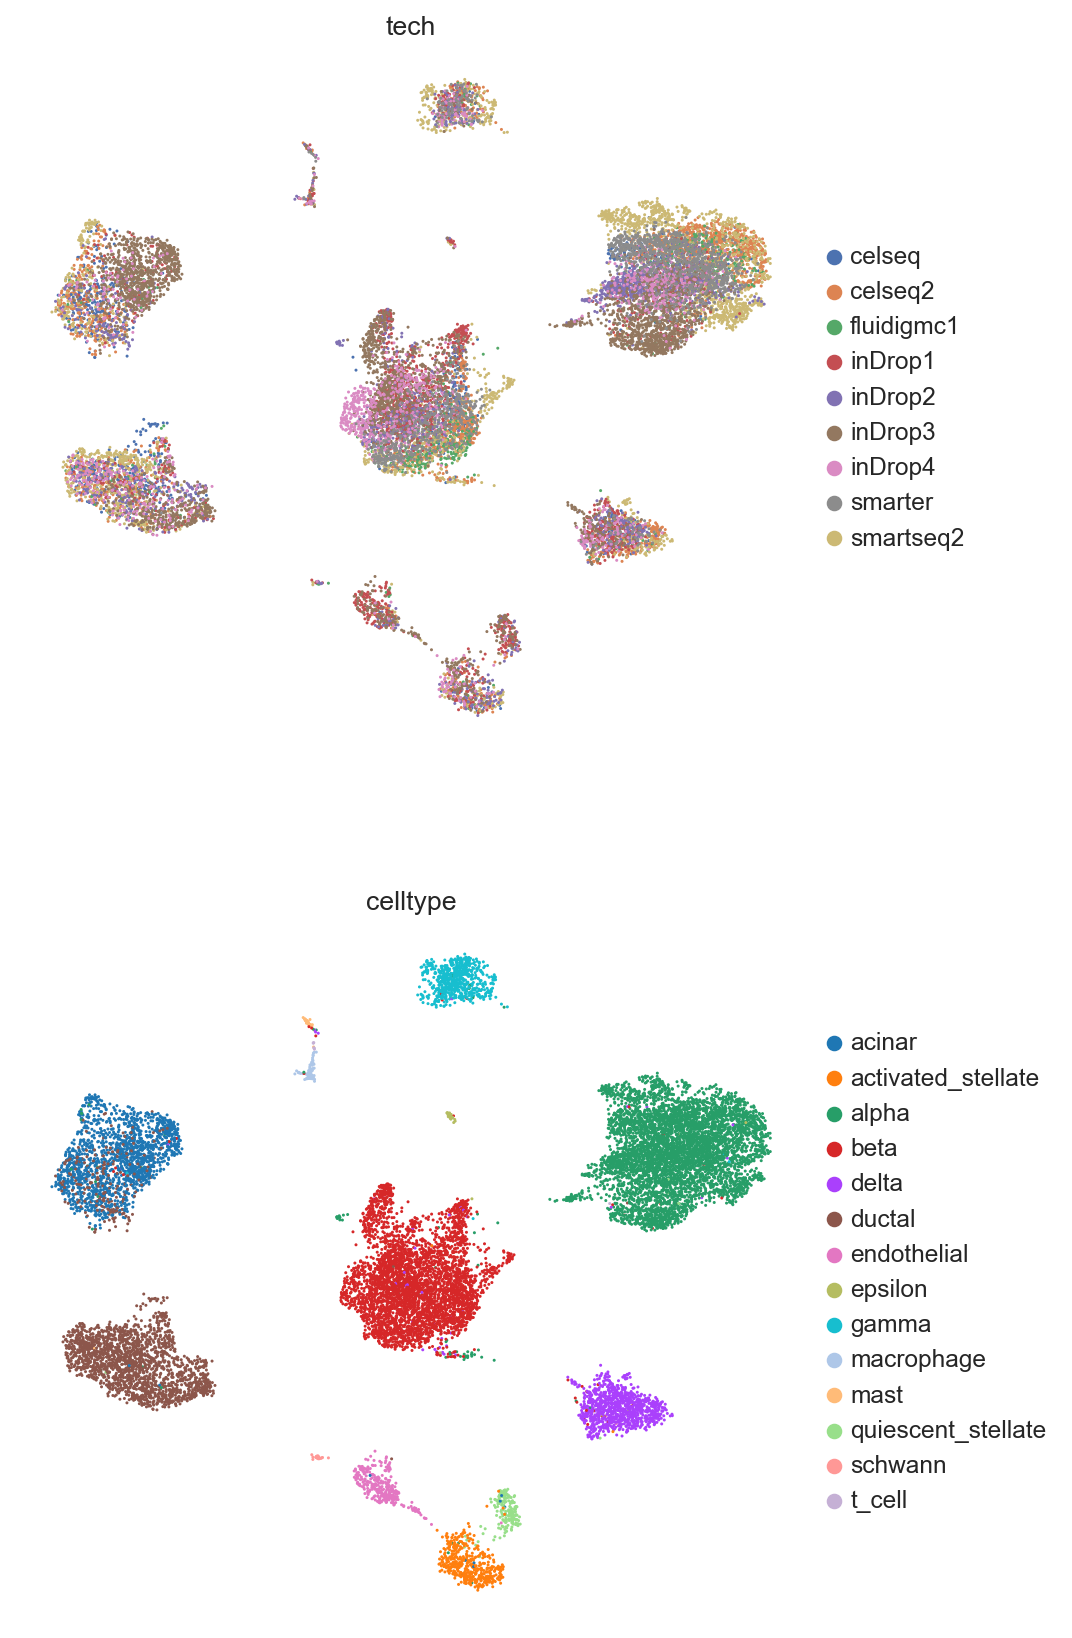

In [104]:
sc.pl.umap(adata, color=["tech", "celltype"], frameon=False, ncols=1)

In [105]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("./partially_annotated_batches_human_pancreas_50.csv")


## read the embeddings

In [107]:
# Step 1: Read the CSV file into a DataFrame
combined_embeddings = pd.read_csv("./partially_annotated_batches_human_pancreas_50.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [109]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="celltype")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='tech', label_key = 'celltype', embed = 'X_scANVI')

/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/clustering.py:101: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  cluster_function(adata, resolution=res, key_added=cluster_key, **kwargs)


resolution: 0.1, nmi: 0.9194799751943332
resolution: 0.2, nmi: 0.919800287944296
resolution: 0.3, nmi: 0.9191440515523354
resolution: 0.4, nmi: 0.9184447639342832
resolution: 0.5, nmi: 0.9149420673908782
resolution: 0.6, nmi: 0.9168742253475852
resolution: 0.7, nmi: 0.875348995923524
resolution: 0.8, nmi: 0.8581817350348466
resolution: 0.9, nmi: 0.8360096194318544
resolution: 1.0, nmi: 0.8088988121962432
resolution: 1.1, nmi: 0.820307252152621
resolution: 1.2, nmi: 0.8160012989094005
resolution: 1.3, nmi: 0.7726064434576739
resolution: 1.4, nmi: 0.7579420274458056
resolution: 1.5, nmi: 0.7443267603652723
resolution: 1.6, nmi: 0.7319701282337893
resolution: 1.7, nmi: 0.7233383786752182
resolution: 1.8, nmi: 0.7210826219890043
resolution: 1.9, nmi: 0.7178645288733316
resolution: 2.0, nmi: 0.6992274747097305
optimised clustering against celltype
optimal cluster resolution: 0.2
optimal score: 0.919800287944296


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_scANVI
Isolated labels ASW...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/ana

In [110]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="celltype")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='tech', label_key = 'celltype', embed = 'X_scgen')

resolution: 0.1, nmi: 0.7671701809961688
resolution: 0.2, nmi: 0.7857213334509824
resolution: 0.3, nmi: 0.784873375627471
resolution: 0.4, nmi: 0.7447311099498819
resolution: 0.5, nmi: 0.7310035742337456
resolution: 0.6, nmi: 0.7259229144002391
resolution: 0.7, nmi: 0.7253038776367773
resolution: 0.8, nmi: 0.7311146619955364
resolution: 0.9, nmi: 0.7228225403799013
resolution: 1.0, nmi: 0.7121120012367793
resolution: 1.1, nmi: 0.7121538881589267
resolution: 1.2, nmi: 0.7122528094617496
resolution: 1.3, nmi: 0.7102789770600665
resolution: 1.4, nmi: 0.7107128389651507
resolution: 1.5, nmi: 0.710557012489243
resolution: 1.6, nmi: 0.7068020064879703
resolution: 1.7, nmi: 0.6969691596147732
resolution: 1.8, nmi: 0.6935918417756317
resolution: 1.9, nmi: 0.6866236623212439
resolution: 2.0, nmi: 0.6845630492631751
optimised clustering against celltype
optimal cluster resolution: 0.2
optimal score: 0.7857213334509824


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_scgen
Isolated labels ASW...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/ana

In [111]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="celltype")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='tech', label_key = 'celltype', embed = 'X_stacas')

resolution: 0.1, nmi: 0.9257010364184247
resolution: 0.2, nmi: 0.9258634401643066
resolution: 0.3, nmi: 0.9090423026816282
resolution: 0.4, nmi: 0.9026868485585141
resolution: 0.5, nmi: 0.8645356727267705
resolution: 0.6, nmi: 0.8551764342391569
resolution: 0.7, nmi: 0.8353598181104185
resolution: 0.8, nmi: 0.8181465935905801
resolution: 0.9, nmi: 0.784074295756764
resolution: 1.0, nmi: 0.7781712256668836
resolution: 1.1, nmi: 0.7401539934289568
resolution: 1.2, nmi: 0.7281779181586913
resolution: 1.3, nmi: 0.7280009505873801
resolution: 1.4, nmi: 0.719128689694914
resolution: 1.5, nmi: 0.7047173570604358
resolution: 1.6, nmi: 0.697299407401085
resolution: 1.7, nmi: 0.6956067964378466
resolution: 1.8, nmi: 0.694869926634824
resolution: 1.9, nmi: 0.6814567565701538
resolution: 2.0, nmi: 0.6849394214657529
optimised clustering against celltype
optimal cluster resolution: 0.2
optimal score: 0.9258634401643066


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_stacas
Isolated labels ASW...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/ana

In [112]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df

,scANVI,scGEN,STACAS
NMI_cluster/label,0.923873,0.793415,0.925295
ARI_cluster/label,0.950869,0.714036,0.955581
ASW_label,0.593287,0.569778,0.677125
ASW_label/batch,0.872088,0.884005,0.862592
PCR_batch,NaN,NaN,NaN
cell_cycle_conservation,NaN,NaN,NaN
isolated_label_F1,0.089172,0.147368,0.127660
isolated_label_silhouette,0.693752,0.723883,0.673373
graph_conn,0.990826,0.947664,0.982845
kBET,NaN,NaN,NaN
